# *Conexión al Drive*

In [1]:
# prompt: crear conexion a drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
import sys
path='/content/drive/MyDrive/cod/marketing/MarketingprojectG8/data'
os.chdir(path)###volver la carpeta del repositorio directorio de trabajo
sys.path.append(path)### agregarla al path, para poder leer los archivos de funciones propios como paquetes

# *Librerias*

In [3]:
###paquete para crear y trabajar con bases de datos.
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
#import a_funciones as fn
from mlxtend.preprocessing import TransactionEncoder
import re

# *Conexión a SQL*

In [4]:
# Conectarse a la base de datos
con=sql.connect('db_movies')

In [5]:
# Crear un cursor
cur=con.cursor()### otro tipo de conexión para ejecutar consultas en la bd sin traer ni llevar información

In [6]:
# Obtener una lista de tablas en la base de datos
cur.execute("""SELECT name FROM sqlite_master WHERE type= 'table'; """)
tables = cur.fetchall()
print("Tablas disponibles:", tables)

Tablas disponibles: [('ratings',), ('movies',)]


### *Cargar las tablas en DataFrames*

In [7]:
# Cargar tabla movies
cur.execute('SELECT * FROM movies')
movies_data = cur.fetchall()
movies_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
movies_df = pd.DataFrame(movies_data, columns=movies_columns)


In [8]:
# Mostrar las primeras filas de la tabla
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
# Cargar tabla ratings
cur.execute('SELECT * FROM ratings')
ratings_data = cur.fetchall()
ratings_columns = [description[0] for description in cur.description]  # Obtener nombres de columnas
ratings_df = pd.DataFrame(ratings_data, columns=ratings_columns)

In [10]:
# Mostrar las primeras filas de la tabla
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# *Cerra la conexion*

In [11]:
# Cerrar la conexión
#cur.close()
#con.close()

# *Análisis exploratorio de los datos*

### *Verificar valores nulos en ambas tablas*

In [12]:
# Verificar valores nulos en las tablas
print("Valores nulos en movies:")
movies_df.isnull().sum()

Valores nulos en movies:


,0
movieId,0
title,0
genres,0


In [13]:
print("Valores nulos en ratings:")
ratings_df.isnull().sum()

Valores nulos en ratings:


,0
userId,0
movieId,0
rating,0
timestamp,0


### *Verificar el formatos en la tabla movies*

In [14]:
# Función para separar el nombre de la película y el año
def separar_titulo_year(title):
    # Buscar el patrón de texto para el año (que está entre paréntesis)
    match = re.match(r"^(.*)\s\((\d{4})\)$", title)
    if match:
        # Si encuentra un match, devuelve el nombre y el año
        return match.group(1), int(match.group(2))
    else:
        # Si no encuentra el formato esperado, retorna el título original y un valor nulo para el año
        return title, None

# Aplicamos la función a la columna 'title'
movies_df[['movie_name', 'year']] = movies_df['title'].apply(lambda x: pd.Series(separar_titulo_year(x)))

# Convertir la columna 'year' a entero explícitamente para evitar decimales
movies_df['year'] = movies_df['year'].astype('Int64')  # Usamos 'Int64' para manejar nulos correctamente

# Verificar las primeras filas para asegurarnos de que se hizo correctamente
movies_df[['movieId', 'movie_name', 'year','genres']].head()


,movieId,movie_name,year,genres
0,1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men,1995,Comedy|Romance
3,4,Waiting to Exhale,1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II,1995,Comedy


In [15]:
# Verificar el tipo de dato en la columna 'genres'
print(type(movies_df['genres'][0]))  # Verifica el tipo de la primera entrada

# Si es una lista, no necesitamos dividirla, solo procesarla
if isinstance(movies_df['genres'][0], str):
    # Si los géneros están en formato de cadena, los dividimos
    movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split('|'))

# Verificar cómo quedan los géneros después de la transformación
movies_df['genres'].head()


<class 'str'>


,genres
0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,"[Adventure, Children, Fantasy]"
2,"[Comedy, Romance]"
3,"[Comedy, Drama, Romance]"
4,[Comedy]


### *Análisis de distribuciones y actividad de usuarios*

#### *Distribución de calificaciones*

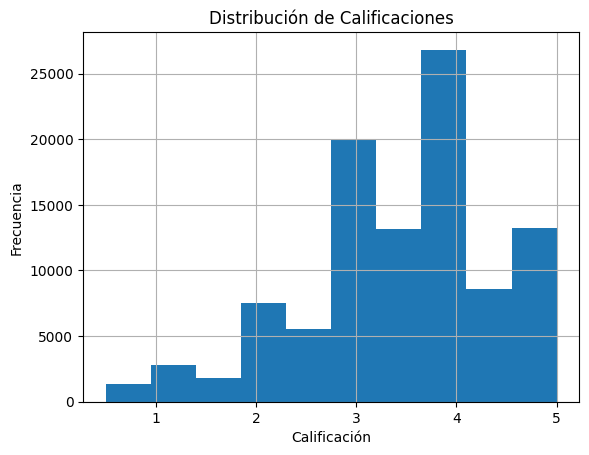

In [16]:
# Histograma de las calificaciones
ratings_df['rating'].hist(bins=10)
plt.title("Distribución de Calificaciones")
plt.xlabel("Calificación")
plt.ylabel("Frecuencia")
plt.show()


Número de usuarios únicos

In [26]:
ratings_by_user = ratings_df.groupby('userId')['rating'].count()

In [28]:
usuarios_unicos = ratings_df['userId'].nunique()
print("Usuarios únicos:", usuarios_unicos)

Usuarios únicos: 610


In [29]:
print("Películas únicas calificadas:", ratings_df['movieId'].nunique()) ### Número de películas únicas calificadas

Películas únicas calificadas: 9724


In [22]:
top_movies = ratings_df['movieId'].value_counts().head(10) ### obtener los IDs de las películas más calificadas
top_movie_ids = top_movies.index.tolist()
top_movies_info = movies_df[movies_df['movieId'].isin(top_movie_ids)] ###filtrar esas películas en el DataFrame de movies
top_movies_counts = top_movies.reset_index() ###unir el conteo de ratings con la información de la película # Creamos un DataFrame del conteo
top_movies_counts.columns = ['movieId', 'rating_count']
top_movies_full = pd.merge(top_movies_counts, top_movies_info, on='movieId') ###Unimos por 'movieId'
top_movies_full = top_movies_full.sort_values(by='rating_count', ascending=False)### mostrar el resultado ordenado por la cantidad de calificaciones
print(top_movies_full[['movie_name', 'year', 'genres', 'rating_count']])### visualizar

                           movie_name  year  \
0                        Forrest Gump  1994   
1           Shawshank Redemption, The  1994   
2                        Pulp Fiction  1994   
3           Silence of the Lambs, The  1991   
4                         Matrix, The  1999   
5  Star Wars: Episode IV - A New Hope  1977   
6                       Jurassic Park  1993   
7                          Braveheart  1995   
8          Terminator 2: Judgment Day  1991   
9                    Schindler's List  1993   

                                  genres  rating_count  
0          [Comedy, Drama, Romance, War]           329  
1                         [Crime, Drama]           317  
2       [Comedy, Crime, Drama, Thriller]           307  
3              [Crime, Horror, Thriller]           279  
4             [Action, Sci-Fi, Thriller]           278  
5            [Action, Adventure, Sci-Fi]           251  
6  [Action, Adventure, Sci-Fi, Thriller]           238  
7                   [Actio

Gráfico de barras que identifica el top 10 peliculas más calificadas.

<ipython-input-23-70a48552ff8c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_count', y='movie_name', data=top_movies_full, palette='viridis')


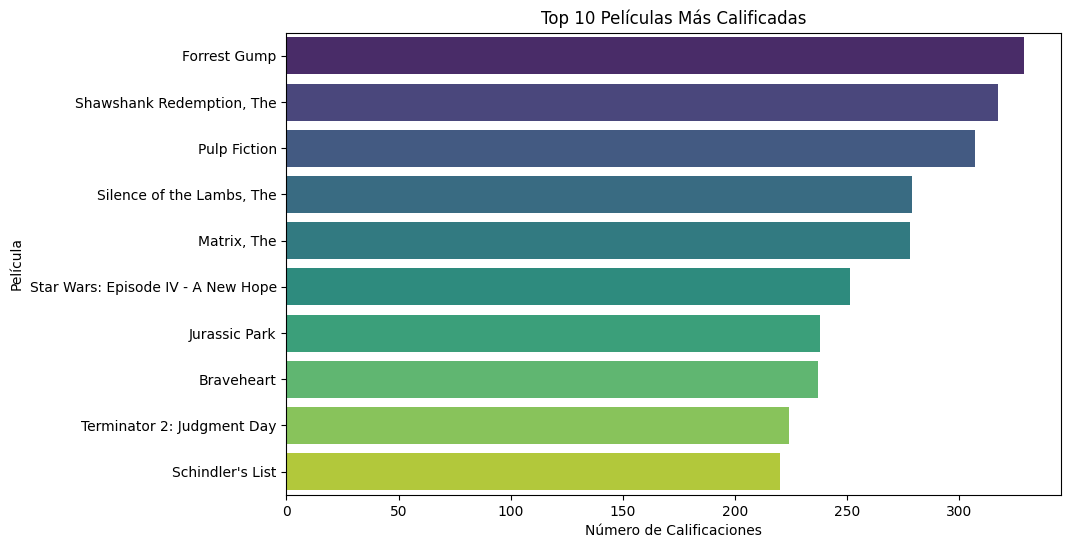

In [23]:
plt.figure(figsize=(10,6))
sns.barplot(x='rating_count', y='movie_name', data=top_movies_full, palette='viridis')
plt.title("Top 10 Películas Más Calificadas")
plt.xlabel("Número de Calificaciones")
plt.ylabel("Película")
plt.show()